# Clustering different pruning rates

In [1]:
# imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import copy

from sklearn.cluster import SpectralClustering, KMeans, AgglomerativeClustering

In [2]:
#p_rates = [30,51,65,76,80,83,88,92,94,96,97]
p_rates = [51,76,83,92,96]
#p_rates = [83,88,92,94,96,97]

In [3]:
# get collective sign distributions for p_rates

def get_collective_sign_distr(n, dataset_name, layer, p_rate):

    # collect all the sign distributions in one huge dataFrame
    coll_sign_distr = pd.DataFrame()
    for i in range(n):
        sign_distr = pd.read_csv(f'2b Sign distributions/more_p_rates/{dataset_name}_IMP{p_rate}_{i}_sign_distr.csv')
        coll_sign_distr = pd.concat([coll_sign_distr, sign_distr])
    # seperate the dataframe by layer
    coll_sign_distr = coll_sign_distr[coll_sign_distr["layer"]==layer][["prune_rate_in", "prune_rate_out", "sign_rate_in", "sign_rate_out"]]
    
    return coll_sign_distr

In [4]:
# get clusters and plot them

def cluster_sign_distr(sign_distr, n_clusters = 2, algorithm = AgglomerativeClustering, print_matrix = False):

    sign_distr = copy.copy(sign_distr)
    
    # preprocess the data
    sign_distr_array = []
    for index, row in sign_distr.iterrows():
        sign_distr_array.append(row.to_numpy())
    sign_distr_array = np.array(sign_distr_array)
    
    # clustering
    clustering = algorithm(n_clusters=n_clusters)
    clustering.fit(sign_distr_array)
    labels = clustering.labels_
    
    # append labels to dataframe
    labels_df = pd.DataFrame(labels, index=range(len(labels)),columns=["cluster"])
    sign_distr = sign_distr.reset_index(drop=True)
    sign_distr = pd.concat([sign_distr, labels_df], axis=1)
    
    # show scatterplot matrix
    if print_matrix:
        sns.pairplot(sign_distr, hue="cluster", height=1.75, kind='scatter', plot_kws={'alpha':0.8})
    
    return sign_distr

In [5]:
# get cluster observations table

def get_cluster_obs(cluster_data, n_clusters = 4):

    cluster_stats = pd.DataFrame()
    for cluster in range(n_clusters):

        cluster_stats_block = pd.DataFrame()
        variables = ["prune_rate_in","prune_rate_out","sign_rate_in","sign_rate_out"]
        for v in variables:

            cluster_data_filtered = cluster_data[cluster_data["cluster"]==cluster]
            #display(cluster_data_filtered)
            cluster_data_filtered = cluster_data_filtered[v]

            cluster_stats_vrow = {}
            cluster_stats_vrow[f"mean_c{cluster}"] = np.mean(cluster_data_filtered)
            cluster_stats_vrow[f"std_c{cluster}"] = np.std(cluster_data_filtered)
            cluster_stats_vrow[f"ratio_c{cluster}"] = len(cluster_data_filtered)/len(cluster_data[v])

            cluster_stats_vrow_df = pd.DataFrame(cluster_stats_vrow, index=[v])
            cluster_stats_block = pd.concat([cluster_stats_block, cluster_stats_vrow_df], axis=0)

        cluster_stats = pd.concat([cluster_stats, cluster_stats_block], axis=1)

    return cluster_stats

In [6]:
def summary_cluster_obs(cluster_stats, n_cluster=4):
        
    cluster_rows = pd.DataFrame()

    # collect all means
    means_names = []
    for n in range(n_cluster):
        means_names.append("mean_c"+str(n))
    means = cluster_stats[means_names]
    means_p_in = list(means.loc["prune_rate_in"])
    means_p_out = list(means.loc["prune_rate_out"])
    means_s_in = list(means.loc["sign_rate_in"])
    means_s_out = list(means.loc["sign_rate_out"])

    for cluster in range(n_cluster):
        cluster_obs = {}

        # for prune in and prune out check whether, highest, lowest or medium
        mean_p_in = cluster_stats.loc["prune_rate_in"][f"mean_c{cluster}"]
        if mean_p_in == np.max(means_p_in):
            cluster_obs["prune_rate_in"] = "highest"
        elif mean_p_in == np.min(means_p_in):
            cluster_obs["prune_rate_in"] = "lowest"
        else:
            cluster_obs["prune_rate_in"] = "medium"
        cluster_obs["prune_rate_in"] = cluster_obs["prune_rate_in"] + f"({np.round(mean_p_in,2)})"

        mean_p_out = cluster_stats.loc["prune_rate_out"][f"mean_c{cluster}"]
        if mean_p_out == np.max(means_p_out):
            cluster_obs["prune_rate_out"] = "highest"
        elif mean_p_out == np.min(means_p_out):
            cluster_obs["prune_rate_out"] = "lowest"
        else:
            cluster_obs["prune_rate_out"] = "medium"
        cluster_obs["prune_rate_out"] = cluster_obs["prune_rate_out"] + f"({np.round(mean_p_out,2)})"

        # for sign in and out check whether balanced, positive or negative
        mean_s_in = cluster_stats.loc["sign_rate_in"][f"mean_c{cluster}"]
        if mean_s_in > 0.55:
            cluster_obs["sign_rate_in"] = "positive"
        elif mean_s_in < 0.45:
            cluster_obs["sign_rate_in"] = "negative"
        else:
            cluster_obs["sign_rate_in"] = "balanced"
        cluster_obs["sign_rate_in"] = cluster_obs["sign_rate_in"] + f"({np.round(mean_s_in,2)})"

        mean_s_out = cluster_stats.loc["sign_rate_out"][f"mean_c{cluster}"]
        if mean_s_out > 0.55:
            cluster_obs["sign_rate_out"] = "positive"
        elif mean_s_out < 0.45:
            cluster_obs["sign_rate_out"] = "negative"
        else:
            cluster_obs["sign_rate_out"] = "balanced"
        cluster_obs["sign_rate_out"] = cluster_obs["sign_rate_out"] + f"({np.round(mean_s_out,2)})"

        # enter the ratio of neurons
        cluster_obs["ratio"] = np.round(cluster_stats.loc["prune_rate_in"][f"ratio_c{cluster}"],2)

        # collect rows in dataframe
        cluster_row = pd.DataFrame(cluster_obs, index=[f"cluster_{cluster}"])
        cluster_rows = pd.concat([cluster_rows, cluster_row], axis=0)
        
    cluster_rows = cluster_rows.sort_values("ratio",ascending=False)
    cluster_names = []
    for n in range(n_cluster):
        cluster_names.append("cluster_"+str(n))
    cluster_rows.index = cluster_names
    return cluster_rows

/net/projects/scratch/summer/valid_until_31_January_2025/epetersen/miniconda3/envs/thesis/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/net/projects/scratch/summer/valid_until_31_January_2025/epetersen/miniconda3/envs/thesis/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/net/projects/scratch/summer/valid_until_31_January_2025/epetersen/miniconda3/envs/thesis/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before 

,prune_rate_in,prune_rate_out,sign_rate_in,sign_rate_out,ratio
cluster_0,lowest(0.49),highest(0.11),balanced(0.51),balanced(0.51),0.54
cluster_1,highest(0.56),lowest(0.1),negative(0.39),balanced(0.5),0.27
cluster_2,medium(0.55),medium(0.11),balanced(0.46),balanced(0.5),0.19


,prune_rate_in,prune_rate_out,sign_rate_in,sign_rate_out,ratio
cluster_0,lowest(0.73),medium(0.17),balanced(0.52),balanced(0.51),0.55
cluster_1,highest(0.82),highest(0.2),negative(0.44),balanced(0.5),0.36
cluster_2,medium(0.82),lowest(0.15),negative(0.28),balanced(0.5),0.09


,prune_rate_in,prune_rate_out,sign_rate_in,sign_rate_out,ratio
cluster_0,lowest(0.81),medium(0.2),balanced(0.52),balanced(0.52),0.62
cluster_1,medium(0.89),highest(0.24),negative(0.45),balanced(0.51),0.28
cluster_2,highest(0.91),lowest(0.17),negative(0.31),balanced(0.5),0.10


,prune_rate_in,prune_rate_out,sign_rate_in,sign_rate_out,ratio
cluster_0,lowest(0.91),medium(0.24),balanced(0.51),balanced(0.52),0.60
cluster_1,highest(0.95),highest(0.31),negative(0.44),balanced(0.51),0.33
cluster_2,medium(0.93),lowest(0.22),positive(0.71),positive(0.58),0.07


,prune_rate_in,prune_rate_out,sign_rate_in,sign_rate_out,ratio
cluster_0,lowest(0.96),medium(0.28),balanced(0.52),balanced(0.52),0.52
cluster_1,medium(0.97),highest(0.36),balanced(0.45),balanced(0.51),0.39
cluster_2,highest(0.98),lowest(0.26),positive(0.81),positive(0.59),0.09


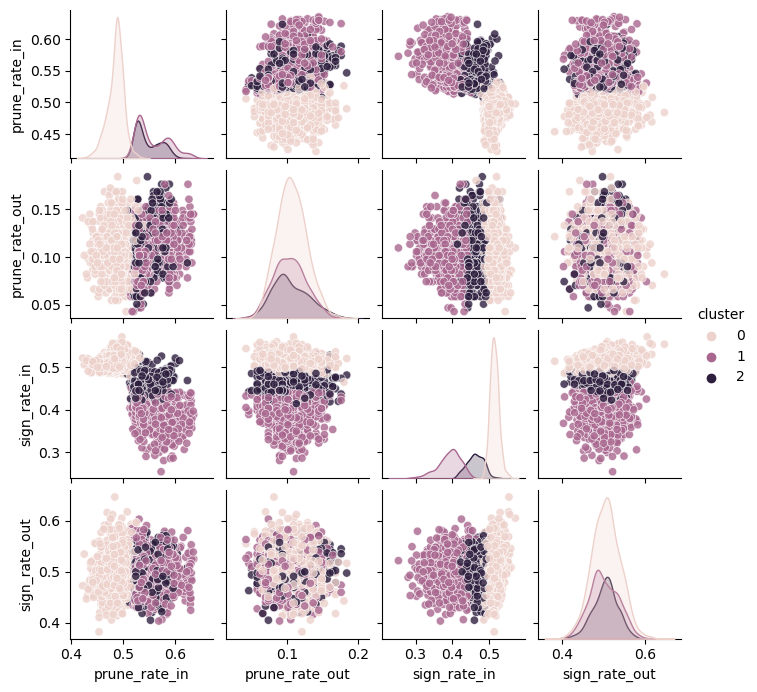

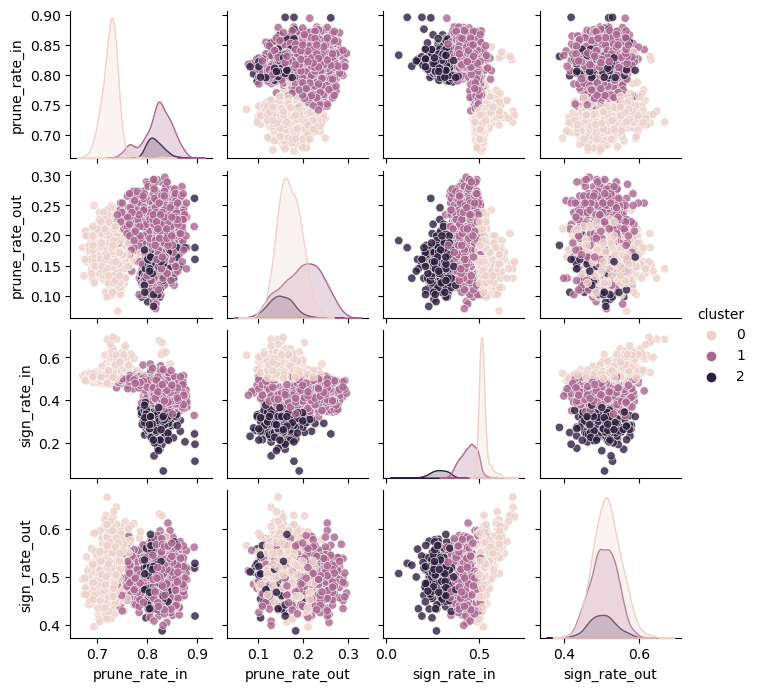

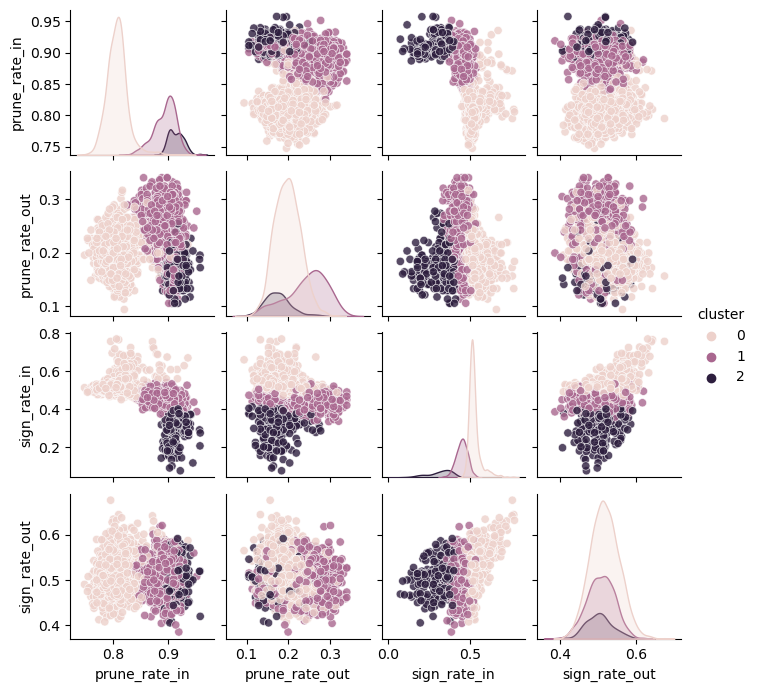

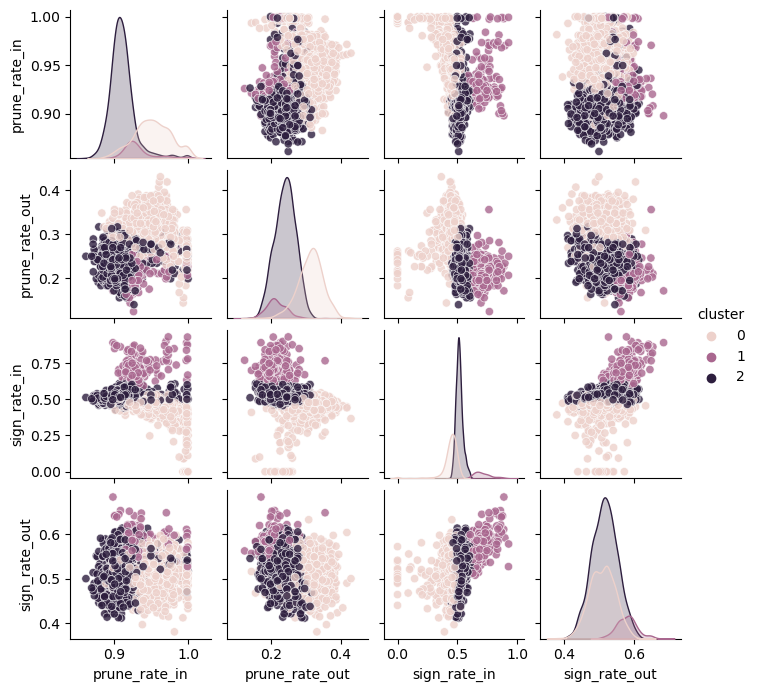

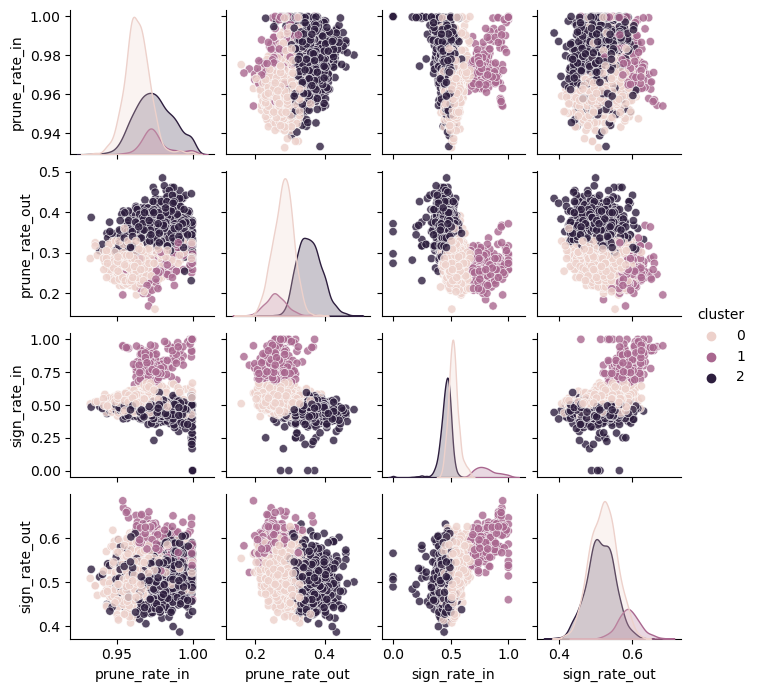

In [7]:
cluster_obs = []

# print cluster matrixes
for p_rate in p_rates:

    # cluster collective sign distributions
    coll_sign_distr = get_collective_sign_distr(10, "CIFAR","dense1", p_rate)
    cluster_data = cluster_sign_distr(coll_sign_distr, n_clusters=3, algorithm=AgglomerativeClustering, print_matrix=True)

    # collect cluster observations
    obs = get_cluster_obs(cluster_data)
    obs_summary = (summary_cluster_obs(obs,3))
    cluster_obs.append(obs_summary)

# print cluster obs
for obs in cluster_obs:
    display(obs)